# Modeling with Text Only to Predict Sentiment

In [2]:
# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## week 3 imports
import missingno as msno     # msno.bar(titanic);  or msno.matrix(titanic);
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Linear and general modeling imports
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Feature Engineering
from sklearn.impute import SimpleImputer   # Imputation 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures   # Scale/transform/feature engineering

import patsy
# y, X = patsy.dmatrices(formula, data=diamonds, return_type='dataframe')

# GridSearch and Hyperparameter Tuning
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

# Logistic and Classification metrics
from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score, classification_report

# K Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.preprocessing import StandardScaler

# naive bayes imports
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

# SVMs
from sklearn.svm import LinearSVC, SVC

# Decision Trees
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# Import Bagging, Boosting, and Random Forests, and ExtraTrees (Extremely Randomized Trees)
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, AdaBoostClassifier, AdaBoostRegressor, RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor

# NLP imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# nltk.download()  --> Download all, and then restart jupyter lab
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag
import re

import json

In [3]:
df = pd.read_csv('../../data/clean_tweets.csv')
df.head()

,airline_sentiment,retweet_count,text,tweet_created,tweet_day,tweet_month,tweet_hour,airline_Delta,airline_Southwest,airline_US Airways,airline_United,airline_Virgin America,clean_text_stem,sentiment_score,clean_word_count
0,neutral,0,I didn't today... Must mean I need to take an...,2015-02-24 11:15:48-08:00,1,2,11,0,0,0,0,1,today must mean need take anoth trip,0.000000,7
1,negative,0,"it's really aggressive to blast obnoxious ""en...",2015-02-24 11:15:36-08:00,1,2,11,0,0,0,0,1,realli aggress blast obnoxi entertain guest fa...,-0.058824,10
2,negative,0,seriously would pay $30 a flight for seats th...,2015-02-24 11:14:33-08:00,1,2,11,0,0,0,0,1,serious would pay 30 flight seat play realli b...,-0.041667,12
3,positive,0,"yes, nearly every time I fly VX this “ear wor...",2015-02-24 11:13:57-08:00,1,2,11,0,0,0,0,1,ye nearli everi time fli vx ear worm go away,0.000000,10
4,neutral,0,Really missed a prime opportunity for Men Wit...,2015-02-24 11:12:29-08:00,1,2,11,0,0,0,0,1,realli miss prime opportun men without hat par...,0.000000,11


In [4]:
# Finds the baseline accuracy
df['airline_sentiment'].value_counts(normalize=True)

negative    0.710114
neutral     0.165570
positive    0.124316
Name: airline_sentiment, dtype: float64

In [5]:
# Sets up X and y
X = df['clean_text_stem']
y = df['airline_sentiment']

In [6]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    random_state=42)

In [7]:
# Instantiates a pipeline
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('abc', AdaBoostClassifier())
])

In [8]:
# Creates the pipe parameters 
pipe_params = {
    'cvec__max_features': [4000, 5000],
    'cvec__min_df':[1, 2],
    'cvec__max_df':[0.90, 0.98],
    'cvec__ngram_range':[(1,2)],
    'abc__learning_rate': [1.0, 0.1, 0.01],
    'abc__n_estimators': [100, 150]
}

In [9]:
# Instantiates the GridSearchCV
gs = GridSearchCV(pipe, 
                param_grid=pipe_params,
                cv=5, 
                verbose=1,
                n_jobs = 4)

In [10]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   27.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:  3.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('abc', AdaBoostClassifier())]),
             n_jobs=4,
             param_grid={'abc__learning_rate': [1.0, 0.1, 0.01],
                         'abc__n_estimators': [100, 150],
                         'cvec__max_df': [0.9, 0.98],
                         'cvec__max_features': [4000, 5000],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 2)]},
             verbose=1)

In [11]:
train1, test1 = gs.score(X_train, y_train), gs.score(X_test, y_test)
train1, test1

(0.7831891223733004, 0.7760474601408973)

In [12]:
gs.best_params_

{'abc__learning_rate': 1.0,
 'abc__n_estimators': 150,
 'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2)}

In [20]:
features = gs.best_estimator_.named_steps['cvec'].get_feature_names()
len(features)

5000

In [21]:
imp = gs.best_estimator_.named_steps['abc'].feature_importances_
len(imp)

5000

In [23]:
imp

array([0., 0., 0., ..., 0., 0., 0.])

In [26]:
# importance_df = pd.DataFrame({'features': features}, 
#                              {'importances': imp})
# importance_df

---

In [27]:
# Instantiates a pipeline 
pipe = Pipeline([
    ('cvec', CountVectorizer(max_df=0.9, max_features=5000, min_df=1, ngram_range=(1,2))),
    ('abc', AdaBoostClassifier(n_estimators=150))
])

In [28]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=5000,
                                 ngram_range=(1, 2))),
                ('abc', AdaBoostClassifier(n_estimators=150))])

In [30]:
train1, test1 = pipe.score(X_train, y_train), pipe.score(X_test, y_test)
train1, test1

(0.7831891223733004, 0.7760474601408973)

In [32]:
# Creates the model metrics row dataframe and saves it as a csv file to be added to the final model metrics table in the presentation
results = pd.DataFrame({'Model': ['AdaBoost'], 
                        'Transformer': ['CountVectorizer'],
                        'Train_acc': [train1],
                        'Test_acc': [test1]})
results.to_csv('../../data/abc_text.csv')

In [33]:
importances = pipe.named_steps['abc'].feature_importances_
importances

array([0., 0., 0., ..., 0., 0., 0.])

In [34]:
features = pipe.named_steps['cvec'].get_feature_names()
features

['00',
 '000',
 '000 feet',
 '000 mile',
 '03',
 '05',
 '10',
 '10 24',
 '10 30',
 '10 day',
 '10 hour',
 '10 hr',
 '10 min',
 '10 minut',
 '10 year',
 '100',
 '100 peopl',
 '1000',
 '10pm',
 '11',
 '11 30',
 '11 hr',
 '11am',
 '12',
 '12 hour',
 '12 hr',
 '1200',
 '13',
 '130',
 '136',
 '13th',
 '14',
 '14 hour',
 '140',
 '15',
 '15 flight',
 '15 hour',
 '15 min',
 '15 minut',
 '15 year',
 '150',
 '15min',
 '15th',
 '16',
 '1600',
 '17',
 '18',
 '180',
 '1800',
 '19',
 '1hr',
 '1hr delay',
 '1k',
 '1pm',
 '1st',
 '1st class',
 '1st flight',
 '1st time',
 '20',
 '20 min',
 '20 minut',
 '20 peopl',
 '200',
 '200 fee',
 '2014',
 '2015',
 '20min',
 '21',
 '22',
 '23',
 '24',
 '24 hour',
 '24 hr',
 '24hr',
 '25',
 '25 min',
 '25 minut',
 '250',
 '26',
 '27',
 '28',
 '28 tweet',
 '29',
 '2d',
 '2d 3d',
 '2day',
 '2hr',
 '2hr delay',
 '2nd',
 '2nd time',
 '2pm',
 '2x',
 '30',
 '30 flight',
 '30 min',
 '30 minut',
 '300',
 '3056',
 '30a',
 '30am',
 '30min',
 '30pm',
 '32',
 '34',
 '35',
 '35 

In [36]:
importance_dict = pd.DataFrame({'feature_importance': importances,
                                'features': features})
top10 = importance_dict.nlargest(10, columns=['feature_importance'])
top10

,feature_importance,features
4305,0.020000,thank
3073,0.013333,need
17,0.006667,1000
66,0.006667,20min
177,0.006667,777
224,0.006667,ad
229,0.006667,admir club
242,0.006667,agent
264,0.006667,airlin
307,0.006667,alway


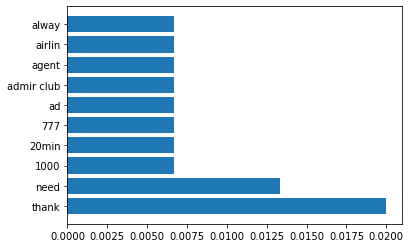

In [40]:
plt.barh(top10['features'], top10['feature_importance']);
plt.savefig('../../presentation/abc_text_featureImp.jpg')